# Techniques of High Performance Computing - Assignment 1

## Name: John Duffy

## Student Number: 19154676

# Question 1

## Random Walk on a Lattice

### Program Description

A particle is positioned at each of the (x, y) coordinates of a N x N lattice grid.
M simualtions are carried out to determine the probability of each particle reaching
the bottom boundary of the grid during a random walk of up to S steps.

This is a compute bound problem, as there is no data shared between simulations.
The result of each simualtion is independent and the result is success (if the bottom
boundary is reached) or failure (if any other boundary is reached, or S steps are
completed without a boundary being reached). A data structure is used to count the
number of successes, which is subsequently turned into a probability.

This is an integer problem. The random walks are implemented as a single integer
step up, down, left or right. And the success counts are integer. Therefore, to avoid
floating point overhead, as much as possible is done using integer data
structures (which also results in a memory saving) and integer operations. A floating
point data sructure is used at the end of the program to store the probabilties.

Numpy arrays are used at the outset as the data structure to store the random walk
success counts (an integer array) and the resulting probabilities (a float array). 
Matplotlib is then used to display the probabilities.

#### Program Structure Optimisation

Because this is a compute bound problem, the structure of the program was consisdered
carefully to ensure function calls and repeated operations are minimised. Function/library
calls considered likely to be expensive, e.g. numpy.random.ranint(), are done once outside
of a loop rather than multiple times inside a loop.

#### Pre Optimisation Results

Using only Numpy the following baseline results were obtained:

* M: 1000
* N: 50

* Time: 689 seconds
* CPU Load: 13% (suggesting at best 1 of 4 core is being utilised)


##### 2019-10-19_Refinement_1

The important thing is that each grid position is exposed to M independent random walks. It
not important that each grid position is exposed to different M independent random walks.
So, rather compute S random walk steps for each grid position for each simulation (M * N * N
calls to numpy.random.randint()), we can compute S random walk steps for each simulation and
apply the same steps to each grid position (M calls to numpy.random.randint()). A saving of
a factor of N * N calls to numpy.random.randint(). This also has the added benefit of moving
the numpy.random.randint() call out of the random_walk() function making it easier to
further optimise this function. The S random walk steps are now passed into random_walk() as
a parameter.

* M: 1000
* N: 50
* S: N * N

* Time: 677 seconds. Eh? Surprising and disappointing! Passing steps array problematic?

* CPU Load: 13%

#### Optimisation Results

##### 2019-10-19_Refinement_1

Added @njit decorator to random_walk() function.

* M: 1000
* N: 50

* Time: 5.2 seconds (a factor 100 reduction in time, for the same CPU load!)
* CPU Load: 13%

##### 2019-10-23_Refinement_1

Created a lattice_random_walk() function with the @njit(parallel=True) decorator. This function
calls random_walk() for each lattice position, using prange to do this in parallel.

Run with M = 1,000

* M: 1000
* N: 50

* Time: 1.5 seconds approx (a factor of 3 - 4 improvement, suggesting all cores utilised)
* CPU Load: 90% (suggest all cores now being utilised)

Run with M = 10,000

* M: 10000
* N: 50

* Time: 15 seconds approx (a linear increase in time)
* CPU Load: 90%

Run with M = 100,000

* M: 100000
* N: 50

* Time: 150 seconds approx (a linear increase in time)
* CPU Load: 90%


In [1]:
# Import the required libraries and functions.

import numpy as np
import numexpr as ne
import time

import matplotlib.pyplot as plt

from numba import njit, prange

In [2]:
# Declare gloabl variables.

# Although it is generally bad programming practice to use global variables which
# can lead to spaghetti code, on some occassions they can aid readability and reduce
# repetition. Use sparingly.

# As per the numexpr documetation, specific mathematical constants are not defined.
# And numexpr seems to have problems with np.pi, so let's declare PI here.

PI = 3.14159265358979323846


In [3]:
# Declare a useful timer class.

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


In [4]:
@njit
def random_walk(x, y, n, steps):
    """
    This function takes as input the (x, y) position of a particle on an n x n grid, and then
    takes up to n * n random walk steps up, down, left or right. The function returns True if the
    bottom boundary is reached, or the bottom boundary is the initial position. The function
    returns False if n * n steps are taken and no boundary is reached, or as soon as the
    top, left or right boundarie are reached.
    
    The intention is to Just in Time compile this function using Numba/njit, so this code is
    as close to simple 'C' like as possible.
    """
 
    # Parameter sanity checks...
    
    assert x >= 1 and x <= n, "x bound error"
    assert y >= 1 and y <= n, "y bound error"
    
 
    # If the intial position of the particle is on a boundary, no need to start a random walk.
    # The order of tests selected to return True as soon as possible.
    
    if y == 1: return True  # Bottom   
    if y == n: return False # Top    
    if x == 1: return False # Left    
    if x == n: return False # Right
    

    # Store initial (x, y) position...
    
    new_x = x
    new_y = y
    

    # Start the random walk with the step directions defined as...

    # 0 == down
    # 1 == up
    # 2 == left
    # 3 == right
    
    for i in range(n * n):

        # Take a step, and test for a boundary conditions as soon as possible...

        if steps[i] == 0:
            new_y -= 1
            if new_y == 1:
                return True

        if steps[i] == 1:
            new_y += 1
            if new_y == n:
                return False
            
        if steps[i] == 2:
            new_x -= 1
            if new_x == 1:
                return False

        if steps[i] == 3:
            new_x += 1
            if new_x == n:
                return False
    

    # Boundary not reached...
    
    return False


In [5]:
@njit(parallel=True)
def lattice_random_walk(n, steps, successes):
    """
    This function counts the number of successes in reaching the bottom boundary of
    an n x n grid after steps number of steps.
    """
    for x in range (1, n + 1):
        for y in prange (1, n + 1):
            if random_walk(x, y, n, steps):
                successes[x - 1, y - 1] += 1
    

In [6]:
# Run M random walk simualtions on each (x, y) position of a N x N lattice.

M = 10000
N = 50

with Timer() as t:

    # Define a successes array. This array counts the numbers of times the bottom boundary
    # is reached for each position on the lattice over M simualtions. Success counts are
    # integers so this array can use an integer datatype so save some memory, reduce cache
    # hits and reduce floating point overhead.
    
    successes = np.zeros((N, N), dtype='uint32')


    # Define a probabilities array. Probabilities are calculated at the end of the program 
    # to avoid floating point overhead.

    probabilities = np.zeros((N, N))


    # Conduct M simulations.
    
    for m in range(M):
        
        # The call to np.random.randint() appears probelmatic for Numba. So, for each simulation
        # generate the random steps that will be taken in advance and pass as a parameter to
        # lattice_random_walk().
        
        steps = np.random.randint(4, size=N*N)
        
        
        # Conduct a random walk over the lattice.
        
        lattice_random_walk(N, steps, successes)
        

    # Determine the probabilities.
    
    probabilities = successes / M
    

print("Total time: {0}".format(t.interval))


Total time: 17.193515062332153


In [7]:
# Print the probabilites array for a sanity check.

# NB We are using (1..N, 1..N) as (x, y) coordinates in a Cartesian sense, but Numpy
# uses [row, column] starting in the top left. This means the Cartesian [x = 1, y = 1)
# position is the top left [row = 1, col = 1] ndarray position. So, we will need to
# rotate the array 90 degrees left for viewing.

print(probabilities)


[[1.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 5.006e-01 3.045e-01 ... 7.000e-04 6.000e-04 0.000e+00]
 [1.000e+00 7.010e-01 5.056e-01 ... 1.700e-03 1.100e-03 0.000e+00]
 ...
 [1.000e+00 6.933e-01 4.947e-01 ... 1.700e-03 1.000e-03 0.000e+00]
 [1.000e+00 4.993e-01 3.024e-01 ... 6.000e-04 3.000e-04 0.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]


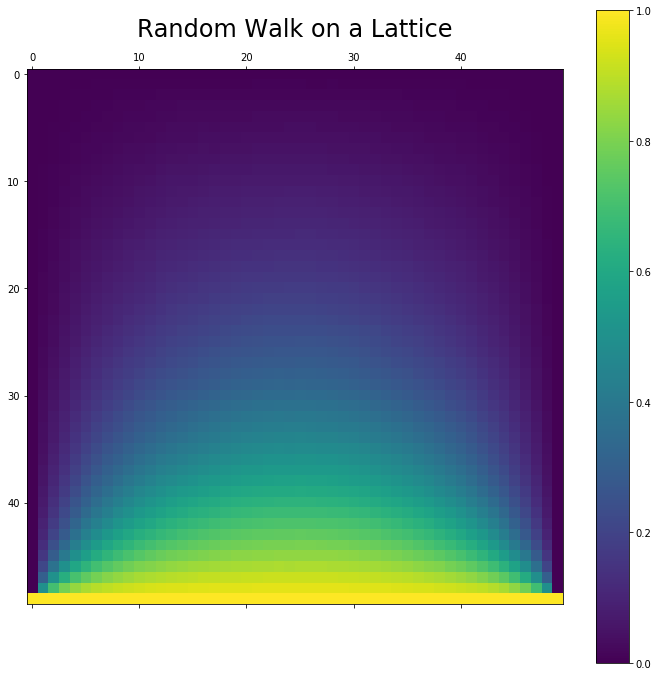

In [8]:
#%matplotlib inline

#import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.0, 12.0))

ax = fig.add_subplot(111)

im = ax.matshow(np.rot90(probabilities)) # Convert from Numpy [row, col] to Cartesian [x, y].

ax.set_title('Random Walk on a Lattice', fontsize=24)

fig.colorbar(im)

plt.show()

## Convergence

To study convergence as the number of random walks M and the number of lattice points N increases, requires a non-dimensional measure of convergence, i.e. one that does not depend upon the size of the lattice. So, as a simple measure of convergence, the average lattice point probability or reaching the bottom boundary was selected, and implemented in the function average_lattice_probability(). This also enables an easy iteration over M and N values.

In [9]:
def average_lattice_probability(m, n):
        
    successes = np.zeros((n, n), dtype='uint32')

    # Define a probabilities array. Probabilities are calculated at the end of the program 
    # to avoid floating point overhead.

    probabilities = np.zeros((n, n))

    # Conduct m simulations.
    
    for i in range(m):
        
        # The call to np.random.randint() appears probelmatic for Numba. So, for each simulation
        # generate the random steps that will be taken in advance and pass as a parameter to
        # lattice_random_walk().
        
        steps = np.random.randint(4, size=n*n)
               
        # Conduct a random walk over the lattice.
        
        lattice_random_walk(n, steps, successes)
        
    # Determine the probabilities.
    
    probabilities = successes / m
    
    # Return the avaerage lattice position probability.
    
    return np.sum(probabilities) / n / n


### Convergence as the Number of Random Walks M increases

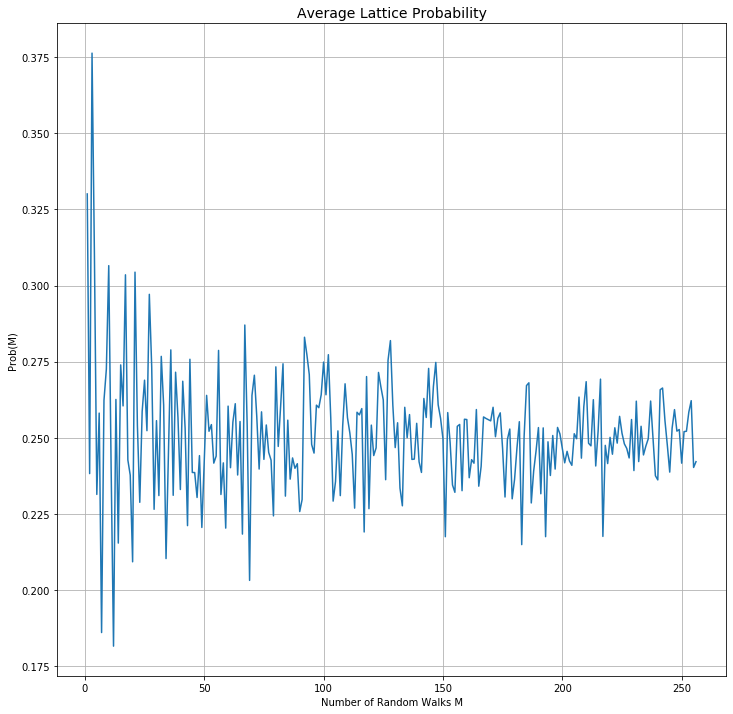

In [10]:
# For a fixed lattice size N x N, determine how the average lattice probability
# varies as M is increased.

M = 256 # Maximum M
N = 32  # Fixed N

average_probability = np.zeros((M))

for i in range(M):
    average_probability[i] = average_lattice_probability(i + 1, N)
    
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(range(1, M + 1), average_probability)

plt.title('Average Lattice Probability', fontsize=14)
plt.xlabel('Number of Random Walks M')
plt.ylabel('Prob(M)')

plt.grid()
plt.show()
    

As can be seen, as the number of random walks increases, for a fixed lattice size, the average
probability of a particle on any position on the lattice reaching the bottom boundary stabilises
to approximately 0.25 after 100 (approximately) random walks. The value of 0.25 is reasonable
since there are 4 boundaries to the lattice and we are measuring the probability of reaching
one of them. This stabilising of the probability is to be expected as an increased number of
random walks will have an averaging and smooothing effect on the probability. Below 50 random
walks results in erratic average probabilities.

### Convergence as the Lattice Size N x N Increases

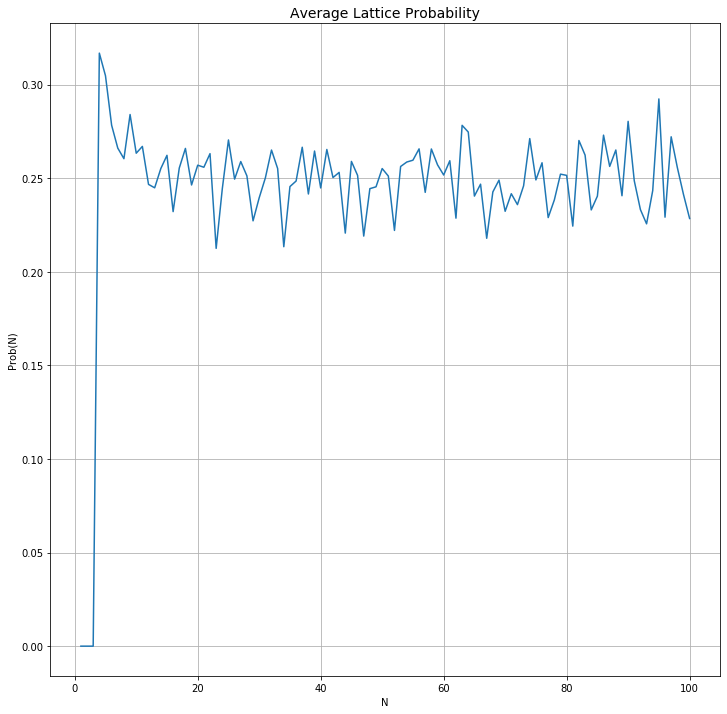

In [11]:
# For a fixed number of random walks, determine how lattice size affects the probability
# as N is increased.

M = 100 # Fixed M
N = 100 # Maximum N

average_probability = np.zeros((N))

for i in range(3, N):
    average_probability[i] = average_lattice_probability(M, i + 1)
    
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(range(1, N + 1), average_probability)

plt.title('Average Lattice Probability', fontsize=14)
plt.xlabel('N')
plt.ylabel('Prob(N)')

plt.grid()
plt.show()
    

Ignoring lattice sizes of less than 4 x 4 in size, from the above it can be seen that the
probability of any particle reaching the bottom boundary is approximately 0.25 and is
independant of the lattice size. Again this is reasonable given there are 4 boundaries to the
lattice. However, this does require further study because for the moment we have set random
walks to terminate after n x n steps if any boundary is not reached.

# Question 2

## Potentials Generated by Random Particles

### Program Description

#### Part I

Part I of the program implements an efficient method to compute and visualise f(r)
for 1 < r < 10. This takes the form of functions f(m, n ,r) and visualise_f(m, n).
The decision to pass the additional parameters m and n into the functions was taken
to reduce any potential problems with global variables, and to make it easier to
iterate of f(m, n, r) for different values of m and n.

#### Part II

Part II uses the function f(m, n, r) implemented in Part I to determine the influence of the
parameters N, M and T (the number of random trials) by calling the function with
differing values of N, M, and T.

### Program Implementation

The circular/angular nature of Question 2 naturally suggests the use of polar co-ordinates.
This will reduce coding complexity by matching the program structure to the problem as
closely as possible.

Polar co-ordinates are not a basic data type in Python so it would be tempting to create
a new 'polar' type to implement the program. But doing so would lead to increased work
and extra complexity. However, complex numbers are a basic type and can be used to
represent circular/angular quantities. With the additional benefit that because they are
a basic type then all of the standard Python operators/functions/libraries can be used
normally. This program uses the complex exponential form of complex numbers in the
function f(r).

### Program Optimisations

Using only Numpy, an initial benchmark for f(512, 1024, 8.0) was timed using %%timeit with the
following result:

6.86 ms ± 79.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



## Part I

### Implement an Efficient Method to Compute and Visualise f(r) for 1 < r < 10

In [12]:
def f(m, n, r, plot=False):
    """
    This function evaluates f(r) with m equally spaced evaluation positions
    on a circle of radius r, and with n randomly positioned unit charges inside
    the unit circle. Both m and n are passed as parameters, as is r. 
    """
    
    # Generate m evenly spaced evaluation positions around a circle of radius r.

    evaluation_positions = np.zeros((m), dtype='complex64')
    
    for i in range(m):
        evaluation_positions[i] = r * np.exp(1j * (2.0 * np.pi / m) * i)


    # Generate n random unit charges inside the unit circle.
    # Note: Numpy random.random() generates a random float [0.0, 1.0).
    
    charge_positions = np.zeros((n), dtype='complex64')
    
    for i in range(n): 
        charge_positions[i] = np.random.random() * np.exp(1j * np.random.random() * (2.0 * np.pi))
        
    
    # Visual sanity check.
    
    if plot == True:

        fig = plt.figure(figsize=(12.0, 12.0))

        for i in range(m):
            plt.polar(np.angle(evaluation_positions[i]), np.absolute(evaluation_positions[i]), 'ro')
    
        for i in range(n):
            plt.polar(np.angle(charge_positions[i]), np.absolute(charge_positions[i]), 'bo')

        plt.title('Evaluation of Function f(m, n, r)', fontsize='14')
        
        plt.show()


    # Calculate the distance between each evaluation position and charge position.
    # the Numpy ufunc subtract.outer() generates the complex number difference between
    # each evaluation position and each charge. The Numpy absolute() function then
    # converts each complex number into a scalar length, the distance.
    
    distances = np.zeros((m, n))
    
    distances = np.absolute(np.subtract.outer(evaluation_positions, charge_positions))
    

    # Calculate the potential for each distance.
    
    potentials = np.zeros((m, n))
    
    potentials = 1.0 / (2.0 * np.pi) * np.log(distances)
    

    # Return the potential per evaluation position per unit charge.
    
    return np.sum(potentials) / m / n


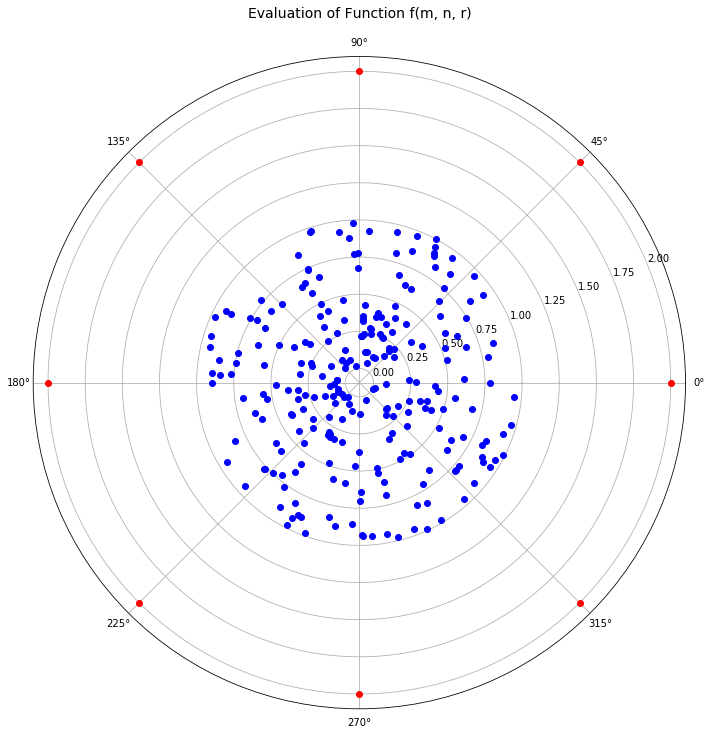

f(8, 256, 2, True) = 0.11031954735517502


In [13]:
# A visual sanity check of the function f(m, n, r)...

m = 8
n = 256
r = 2
p = True # Plot

print('f({m}, {n}, {r}, {p}) = {result}'.format(m=m, n=n, r=r, p=p, result=f(m, n, r, True)))

In [14]:
%%timeit

# A speed check of the function f()...

f(512, 1024, 8.0)


6.9 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
def visualise_f(m, n):
    """
    This function visualises f(m, n, r) in the interval 1 < r < 10 in 0.1 increments.
    """

    fr = np.zeros((89))

    for i in range(89):
        fr[i] = f(M, N, 1.1 + i * 0.1)

    fig = plt.figure(figsize=(12.0, 12.0))

    plt.plot(np.arange(1.1, 10, 0.1), fr)

    plt.xlabel('Radius r', fontsize=14)
    plt.ylabel('Potential f(r)', fontsize=14)

    plt.title('Potentials Generated by Random Particles', fontsize=24)

    plt.grid()
    plt.show()

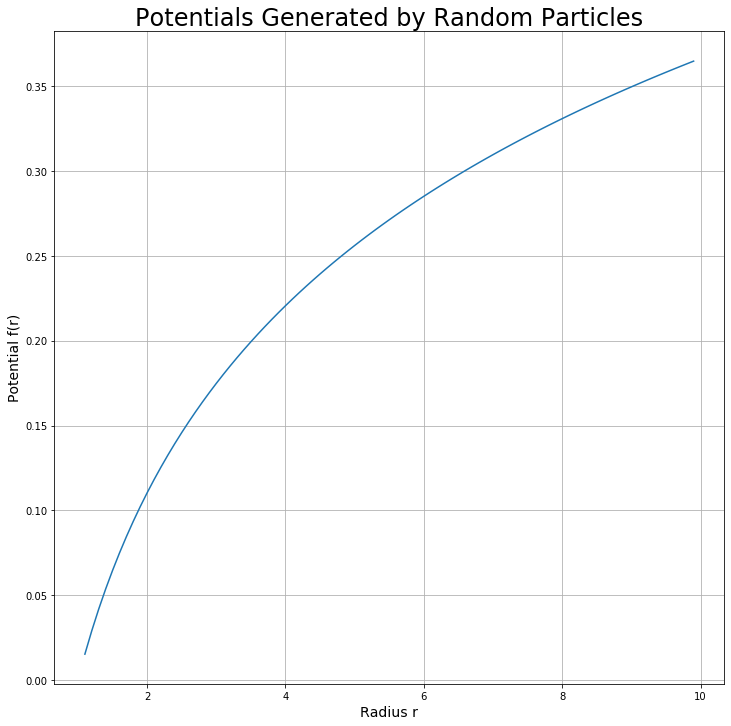

In [16]:
visualise_f(512, 1024)

## Part II

### Estimate the Expected Relative Difference e(r)

A single particle at the centre of the unit circle...

In [17]:
def u0(r):
    """
    This function returns the potential at radius r generated by a single particle
    positioned at the centre of the unit circle.
    """
    
    return 1.0 / (2.0 * np.pi) * np.log(r)


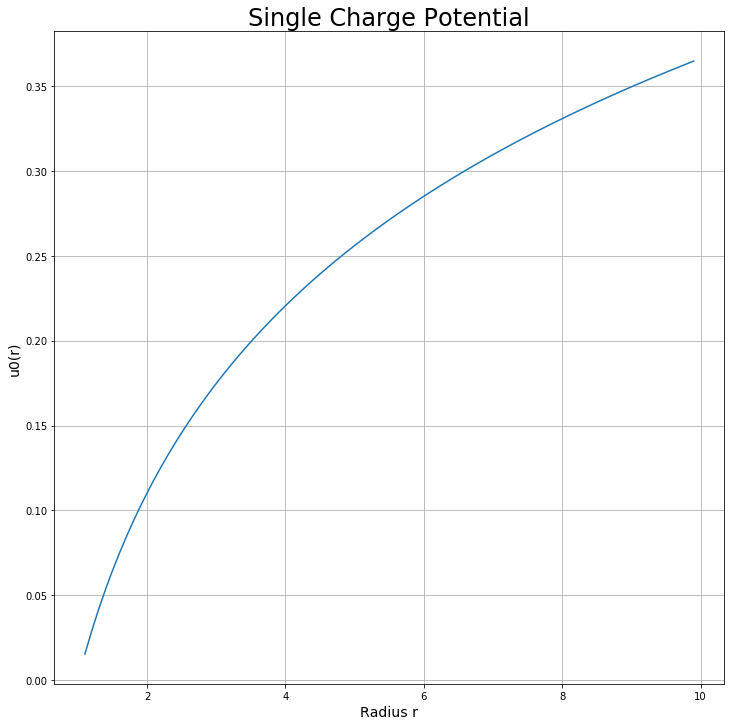

In [18]:
# Plot u0(r).

single_charge_potential = np.zeros((89))

for i in range(89):
    single_charge_potential[i] = u0(1.1 + i * 0.1)

fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(np.arange(1.1, 10, 0.1), single_charge_potential)

plt.xlabel('Radius r', fontsize=14)
plt.ylabel('u0(r)', fontsize=14)

plt.title('Single Charge Potential', fontsize=24)

plt.grid()
plt.show()


In [19]:
%%timeit

# Test u0(r)...

u0(8.0)

794 ns ± 20.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [20]:
def e(m, n, r):
    """
    This function returns the expected value e(r) for the relative difference of u0(r) and f(r).
    Values of m and n are passed as parameters for ease of iteration over parameter values when
    calling this function from outer loops.
    """
    return np.absolute(f(m, n, r) - u0(r)) / u0(r)
    

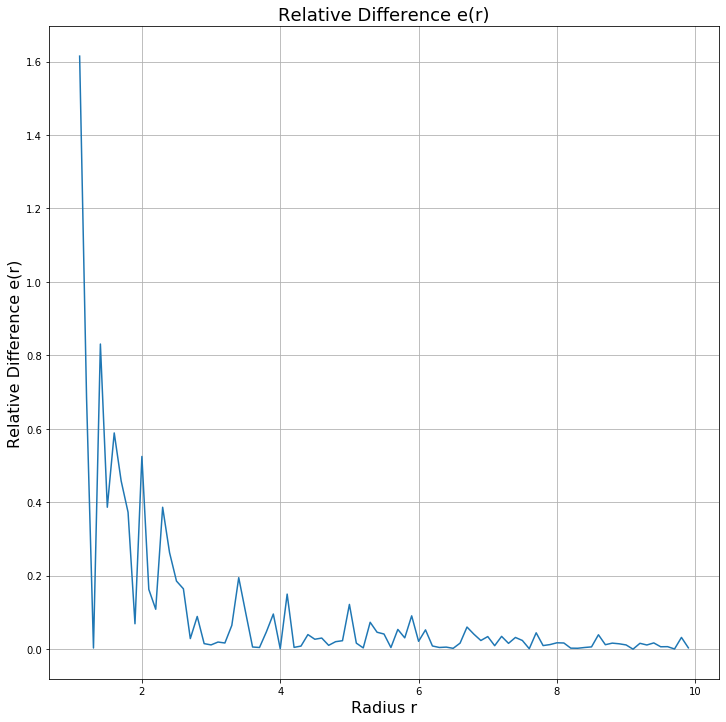

In [62]:
# Plot the expected relative difference for fixed values of M and N. The expected
# relative distance should be the greatest when there is a single randomly placed
# charge and a single evaluation point, so set M = 1 and N = 1.

M = 1
N = 1

relative_difference = np.zeros((89))

for i in range(89):
    relative_difference[i] = e(M, N, 1.1 + i * 0.1)

fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(np.arange(1.1, 10, 0.1), relative_difference)

plt.xlabel('Radius r', fontsize=16)
plt.ylabel('Relative Difference e(r)', fontsize=16)

plt.title('Relative Difference e(r)', fontsize=18)

plt.grid()
plt.show()


With a single evaluation point and a single randomly placed charge there should be the maximum
(dependent upon charge location) deviation from a single charge placed at the centre of the
unit circle. This deviation should be a maximum close to the unit cirle and diminish as r
increases. This can be seen in the plot above.

In [22]:
%%timeit

# Test e(m, n, r)...

e(64, 1024, 2)

2.55 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Influence of M on Relative Difference e(r)

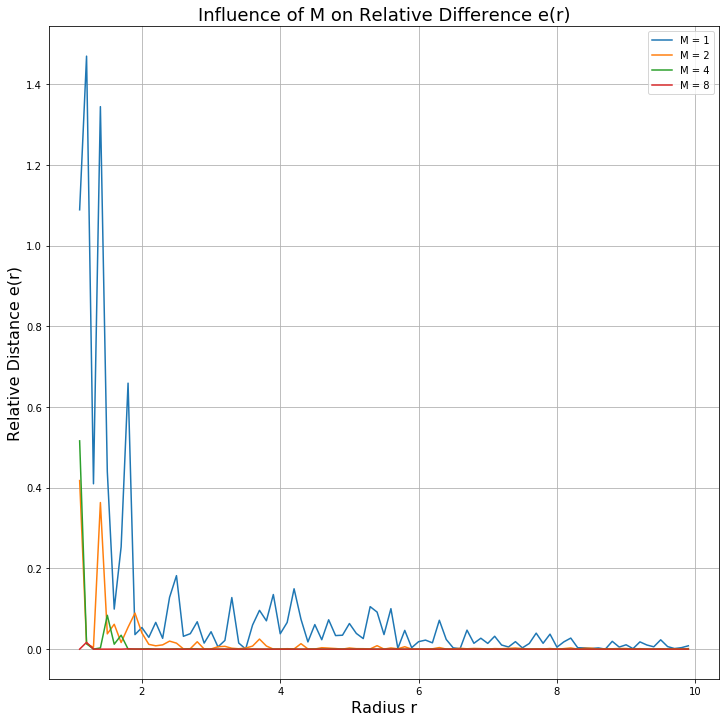

In [58]:
# Investigate the influence of the number of evaluation points M on the relative error
# for a fixed value of randomly placed charges N.

M = [1, 2, 4, 8]
N = 1

relative_difference = np.zeros((4, 89))

for i in range(4): 
    for j in range(89):
        relative_difference[i, j] = e(M[i], N, 1.1 + j * 0.1)
        
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(np.arange(1.1, 10, 0.1), relative_difference[0], label='M = 1')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[1], label='M = 2')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[2], label='M = 4')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[3], label='M = 8')

plt.xlabel('Radius r', fontsize=16)
plt.ylabel('Relative Distance e(r)', fontsize=16)

plt.title('Influence of M on Relative Difference e(r)', fontsize=18)

plt.legend()
plt.grid()
plt.show()


As can be seen from the plot above, the relative difference decreases as M increases. This
is to be expected since the greater the value of M the closer our trapezoidal rule approximation
of f(r) gets to the exact integral f(r).

### Influence of N on Expected Relative Error e(r) 

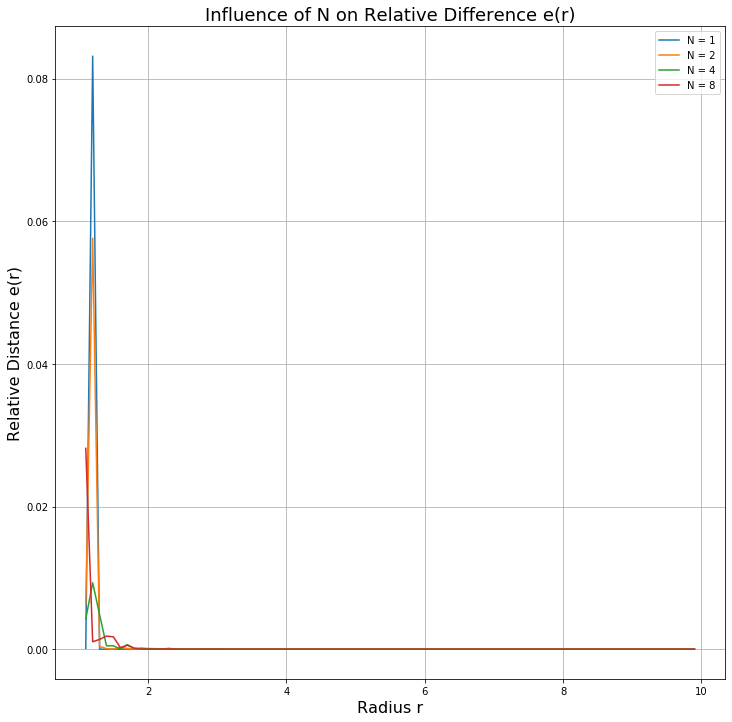

In [57]:
# Investigate the influence of the number of randomly placed charges N on the. From
# the investigation of the influence of M on the relative difference, it was noted
# that a higher value of M reduces the relative difference. So, set M = 8 to
# isolate the effect of M from this investigation.

M = 8
N = [1, 2, 4, 8]

relative_difference = np.zeros((4, 89))

for i in range(4): 
    for j in range(89):
        relative_difference[i, j] = e(M, N[i], 1.1 + j * 0.1)
        
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(np.arange(1.1, 10, 0.1), relative_difference[0], label='N = 1')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[1], label='N = 2')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[2], label='N = 4')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[3], label='N = 8')

plt.xlabel('Radius r', fontsize=16)
plt.ylabel('Relative Distance e(r)', fontsize=16)

plt.title('Influence of N on Relative Difference e(r)', fontsize=18)

plt.legend()
plt.grid()
plt.show()


The evidence from the plot above is less clear cut regarding the influence of N when N is
very low, 1 or 2, due to the random nature of the charge placement. But as N increases the
relative difference decreases. This is to be expected since as the number of randomly
placed charges increases the more the total charge in the unit circle will approximate
a single charge of unit radius.

### Influence of T (Number of Trials) on Relative Difference e(r) 

Increasing the number of trials should smooth out the fluctuations due the nature of the random
charge placement, and therefore give more accurate estimations the relative difference.

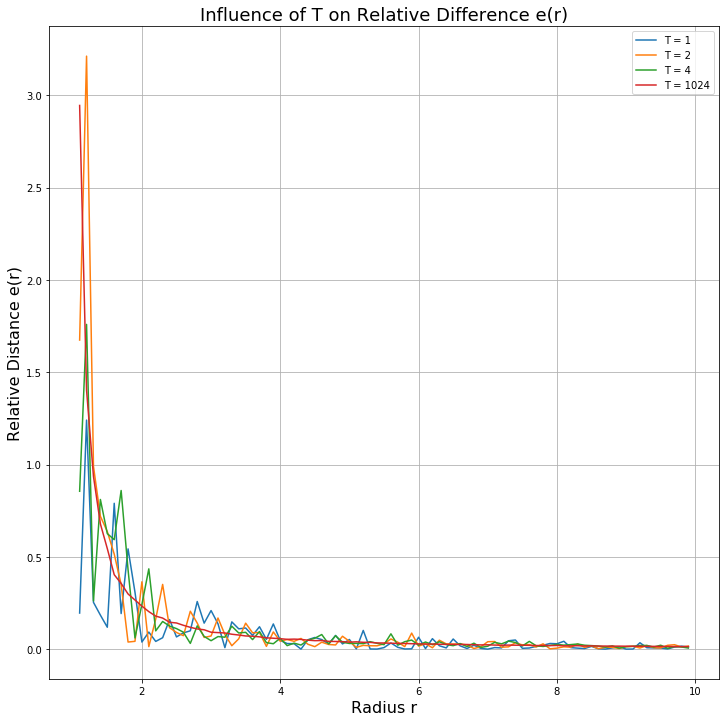

In [66]:
# Plot the expected relative difference for fixed values of M and N for increasing
# number of trials T. The expected relative difference should be the greatest when
# there is a single randomly placed charge and a single evaluation point, so set
# M = 1 and N = 1. But this relative difference should be smoothed out as T
# increases.

T = [1, 2, 4, 1024]

M = 1
N = 1

relative_difference = np.zeros((4, 89))

for i in range(4):
    for j in range(89):
        for k in range(T[i]):
            relative_difference[i, j] += e(M, N, 1.1 + j * 0.1)

for i in range(4):
    relative_difference[i] /= T[i]

fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(np.arange(1.1, 10, 0.1), relative_difference[0], label='T = 1')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[1], label='T = 2')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[2], label='T = 4')
plt.plot(np.arange(1.1, 10, 0.1), relative_difference[3], label='T = 1024')

plt.xlabel('Radius r', fontsize=16)
plt.ylabel('Relative Distance e(r)', fontsize=16)

plt.title('Influence of T on Relative Difference e(r)', fontsize=18)

plt.legend()
plt.grid()
plt.show()


As can be seen form the plot above, as the number of trials T increases this has a smoothing
effect on the relative difference. This is due to the averaging of the single random charge
placement approximating a single charge placed at the centre of the unit circle. This smoothing
effect would be evident in all combinations of M and N. So, for accurate results, conduct as
many trials as possible!